# UNet Like network for Semantic Segmentation

Task: given an image with a MNIST digit with a CIFAR10 background do semantic segmetnation to extract the digit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch as T
import torch.nn as nn

import torchvision

from torch.nn.modules import *

from copy import deepcopy
from tqdm import tqdm, trange
from torchvision import datasets, transforms

## Building the Dataset

In [3]:

T.set_default_tensor_type('torch.FloatTensor')


def get_mnist():
    train_loader = T.utils.data.DataLoader(datasets.MNIST(
        './data', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(), 
            #transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=16, shuffle=True
    ) 
    test_loader = T.utils.data.DataLoader(datasets.MNIST(
        './data', train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=16, shuffle=True
    ) 
    return train_loader, test_loader

mnist_train_loader, mnist_test_loader = get_mnist()
mnist_training_data = mnist_train_loader.dataset.train_data.float()

def get_cifar():
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True,
        download=True, transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=1,
        shuffle=True, num_workers=2
    )
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False,
        download=True, transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=1,
        shuffle=False, num_workers=2
    )
    return trainloader, testloader

cifar_train_loader, cifar_test_loader = get_cifar()
cifar_training_data = T.tensor(cifar_train_loader.dataset.train_data).float().permute(0, 3, 1, 2)

def make_sample(cifar_data, mnist_data):
    random_cifar_img = cifar_data[T.randint(0, len(cifar_data), (1,)).long()][0]
    random_mnist_img = mnist_data[T.randint(0, len(mnist_data), (1,)).long()][0]
    random_mnist_img = random_mnist_img.expand(3, 28, 28)
    random_mnist_img = T.nn.ConstantPad2d(2, 0)(random_mnist_img)
    ground_truth = deepcopy(random_mnist_img[0])
    image = T.max(random_cifar_img, random_mnist_img)
    return (image - 155) / 255., ground_truth > 0


Files already downloaded and verified


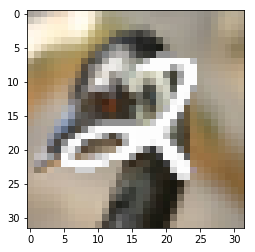

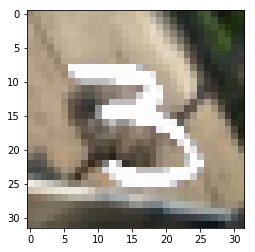

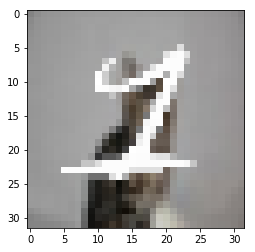

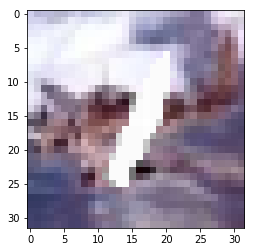

In [4]:
for i in range(4):
    make_sample(cifar_training_data, mnist_training_data)

    img, gt = make_sample(cifar_training_data, mnist_training_data)
    plt.imshow(np.array(img.permute(1, 2, 0) * 255 + 155, dtype=int))
    plt.show()

## Building the UNetLike Model

In [5]:
class ConvBlock(Module):
    def __init__(self, nb_in, nb_out):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(nb_in, nb_out, 3, padding=1),
            nn.BatchNorm2d(nb_out),
            nn.ReLU(),
            nn.Conv2d(nb_out, nb_out, 3, padding=1),
            nn.BatchNorm2d(nb_out),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

    def forward(self, x):
        return self.conv(x)

class UpsamplingBlock(Module):
    def __init__(self, nb_in, nb_out):
        super(UpsamplingBlock, self).__init__()
        self.conv = nn.Sequential(
            #nn.ConvTranspose2d(nb_in, nb_out, kernel_size=2, stride=2),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(nb_in, nb_out, 1),
            #nn.BatchNorm2d(nb_out),
            nn.ReLU()
            #nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.conv(x)


class UNetLike(Module):
    def __init__(self):
        super(UNetLike, self).__init__()
        self.conv1 = ConvBlock( 3, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.ups1 = UpsamplingBlock(64, 64)
        self.ups2 = UpsamplingBlock(128, 64)
        self.ups3 = UpsamplingBlock(128, 64)
        self.ups4 = UpsamplingBlock(128, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv3(x3)
        u1 = T.cat((x3, self.ups1(x4)), dim=1)
        u2 = T.cat((x2, self.ups2(u1)), dim=1)
        u3 = T.cat((x1, self.ups3(u2)), dim=1)
        u4 = self.ups4(u3)
        return Sigmoid()(u4)


## Learning

/usr/local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:221: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")
  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
         ConvBlock-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

100%|██████████| 500/500 [01:48<00:00,  4.59it/s]


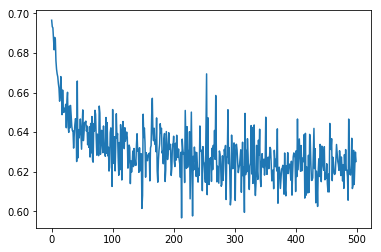

In [6]:
segmenter = UNetLike()
loss_function = BCELoss()
optimizer = T.optim.Adam(segmenter.parameters())

from torchsummary import summary
summary(segmenter, (3, 32, 32))

batch_size = 8
nb_epochs = 500

loss_history = []
for i in trange(nb_epochs):
    x, y = zip(*[make_sample(cifar_training_data, mnist_training_data) for i in range(batch_size)])
    x = T.tensor([m.detach().numpy() for m in x])
    y = T.tensor([m.detach().numpy() for m in y])
    yhat = segmenter(x.view([batch_size, 3, 32, 32]))
    loss = loss_function(
        yhat.squeeze(1),
        y.float()
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

plt.plot(loss_history)
plt.show()

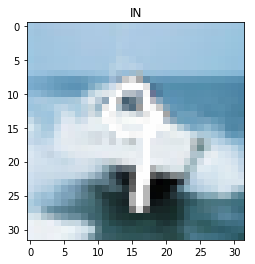

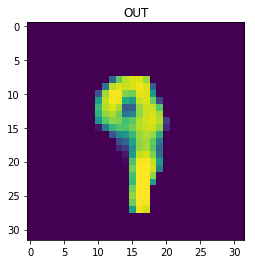

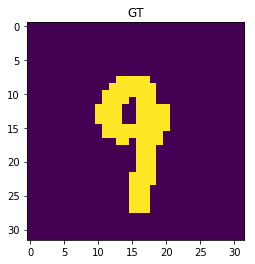

In [7]:
plt.title("IN")
plt.imshow(np.array(x[0].permute(1, 2, 0).detach().numpy() * 255 + 155, dtype=int))
plt.show()

plt.title("OUT")
plt.imshow(yhat[0][0].detach().numpy())
plt.show()


plt.title("GT")
plt.imshow(y[0].detach().numpy())
plt.show()